In [2]:
import numpy as np
import gensim 
vec_1 = np.array([0.6, 0.1, 0.1, 0.2])
vec_2 = [0.2, 0.2, 0.1, 0.5]
result = gensim.matutils.hellinger(vec_1, vec_2)
print(result)

0.309742984153


In [1]:
import pandas as pd
df = pd.read_csv(r'C:\Users\Mouna\Desktop\Masters\Spring2019\Project Work\irma_coded_tweets.csv',dtype='str',encoding='utf-8',error_bad_lines=False,keep_default_na=False)
df['t']=df['tweet'].str.replace('http\S+|www.\S+', '', case=False)
df['t'] = df['t'].str.replace('@', ' ')
df['t'] = df['t'].str.replace('#', ' ')
df['t']=df['t'].str.lower()
from textblob import TextBlob
def split_into_lemmas(message):
    #message=message.lower()
    words = TextBlob(message).words
    # for each word, take its "base form" = lemma 
    return [word.lemma for word in words]
df['t']=df['t'].apply(split_into_lemmas)

from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
stop = stopwords.words('english')
stop.extend(('hurricaneirma','amp','irma','florida','hurrican'))
stemmer = SnowballStemmer("english")
df['t'] = df['t'].apply(lambda x: [stemmer.stem(y) for y in x])
df['t']=df['t'].apply(lambda x: [item for item in x if item not in stop])
df['len']=df['t'].str.len()
df.drop(df[df['len']<=2].index,inplace=True)
tweets = df['t'].tolist()
tweets = [[i for i in nested if len(i) > 2] for nested in tweets]

In [2]:
from gensim.test.utils import common_corpus, common_dictionary
from gensim.models.phrases import Phrases, Phraser
from gensim import corpora, models , similarities
import gensim
def bigrams(words, bi_min=10, tri_min=10):
    bigram = Phrases(words, min_count = bi_min)
    bigram_mod = Phraser(bigram)
    return bigram_mod
    
def get_corpus(df):
    words=df
    bigram_mod = bigrams(words)
    bigram = [bigram_mod[review] for review in words]
    id2word = corpora.Dictionary(bigram)
    corpus = [id2word.doc2bow(text) for text in bigram]
    return corpus, id2word, bigram

train_corpus, train_id2word, bigram_train = get_corpus(tweets)

C:\Users\Mouna\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
lda_model = gensim.models.ldamulticore.LdaMulticore(
                           corpus=train_corpus,
                           num_topics=30,
                           id2word=train_id2word,
                           workers=7, # Num. Processing Cores - 1
                           per_word_topics=True)

In [4]:
import numpy as np
lda_lambda = lda_model.state.get_lambda()
lda_lambda = lda_lambda / lda_lambda.sum(axis=1)[:, np.newaxis] # normalize vector
print(lda_lambda)

[[  7.69301732e-06   7.69301732e-06   7.69301732e-06 ...,   7.69301732e-06
    7.69301732e-06   7.69301732e-06]
 [  7.74258478e-06   7.74258478e-06   7.74258478e-06 ...,   7.74258478e-06
    7.74258478e-06   7.74258478e-06]
 [  6.68523899e-06   3.21640866e-04   6.68523899e-06 ...,   6.68523899e-06
    6.68523899e-06   6.68523899e-06]
 ..., 
 [  7.16318254e-06   7.16318254e-06   7.16318254e-06 ...,   7.16318254e-06
    7.16318254e-06   7.16318254e-06]
 [  7.15946317e-06   7.15946317e-06   7.15946317e-06 ...,   7.15946317e-06
    7.15946317e-06   7.15946317e-06]
 [  9.30954502e-06   9.30954502e-06   9.30954502e-06 ...,   9.30954502e-06
    9.30954502e-06   9.30954502e-06]]


In [5]:
import itertools as itt
edges = [(i, j, {'weight': gensim.matutils.hellinger(lda_lambda[i], lda_lambda[j])})
         for i, j in itt.combinations(range(lda_model.num_topics), 2)]

In [6]:
edges

[(0, 1, {'weight': 0.55743268863959516}),
 (0, 2, {'weight': 0.55878594566630635}),
 (0, 3, {'weight': 0.55920792540662856}),
 (0, 4, {'weight': 0.56568209955311632}),
 (0, 5, {'weight': 0.56480191024370785}),
 (0, 6, {'weight': 0.57067250947081694}),
 (0, 7, {'weight': 0.57801523970936375}),
 (0, 8, {'weight': 0.5573717101419855}),
 (0, 9, {'weight': 0.58584301504633451}),
 (0, 10, {'weight': 0.56430965302962066}),
 (0, 11, {'weight': 0.57430502833729535}),
 (0, 12, {'weight': 0.56294397211192526}),
 (0, 13, {'weight': 0.56159086403092739}),
 (0, 14, {'weight': 0.56970608491030061}),
 (0, 15, {'weight': 0.56640703924716029}),
 (0, 16, {'weight': 0.57161991287794023}),
 (0, 17, {'weight': 0.57062665569320092}),
 (0, 18, {'weight': 0.56203149782270234}),
 (0, 19, {'weight': 0.57365007851852057}),
 (0, 20, {'weight': 0.55692639962462409}),
 (0, 21, {'weight': 0.564224936219759}),
 (0, 22, {'weight': 0.56699798192063722}),
 (0, 23, {'weight': 0.56645031461643824}),
 (0, 24, {'weight': 0.5

0.577236114583


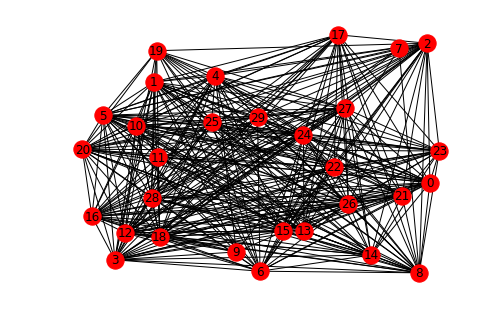

In [7]:
import networkx as nx
import matplotlib.pyplot as plt
G = nx.Graph()
G.add_nodes_from(range(lda_model.num_topics))
k = np.percentile(np.array([e[2]['weight'] for e in edges]), 80)
print(k)
#G.add_edges_from(edges)
pos=nx.spring_layout(G,k=0.9,iterations=1)  
G.add_edges_from([e for e in edges if e[2]['weight'] < k])
nx.draw(G,pos,with_labels=True)

fig=plt.figure()
plt.figure(figsize=(50,50))
plt.show()

In [8]:
from community import community_louvain
parts = community_louvain.best_partition(G)
values = [parts.get(node) for node in G.nodes()]

In [9]:
plt.axis("off")
nx.draw_networkx(G, pos =pos, cmap = plt.get_cmap("jet"), node_color = values,node_size = 600, with_labels = True)

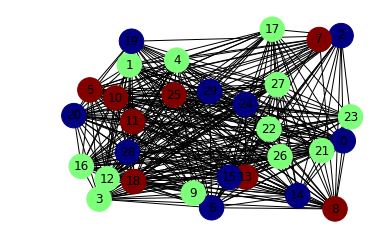

In [10]:
plt.show()

In [11]:
set(values)# 0-Blue 1- Green 2-Red 

{0, 1, 2}

In [130]:
list0=[index for index, value in enumerate(values) if value == 0]
list1=[index for index, value in enumerate(values) if value == 1]
list2=[index for index, value in enumerate(values) if value == 2]

In [123]:
print([index for index, value in enumerate(values) if value == 2],end=" ")

[5, 7, 8, 27, 29, 30, 33, 34, 45, 52, 69, 70, 73, 74, 78] 

In [131]:
lda_model.show_topic(0)

[('storm', 0.013132485),
 ('report_gust', 0.011101884),
 ('mph', 0.011101884),
 ('miami', 0.010608141),
 ('hurricaneirma', 0.010261357),
 ('got', 0.0074046147),
 ('irma', 0.0069108708),
 ('post_photo', 0.0066639986),
 ('florida', 0.0063657374),
 ('hous', 0.0061993222)]

In [159]:
value0_topics=[]
for i in list0:
    value0_topics.extend(lda_model.show_topic(i))   
value1_topics=[]
for i in list1:
    value1_topics.extend(lda_model.show_topic(i)) 
value2_topics=[]
for i in list2:
    value2_topics.extend(lda_model.show_topic(i)) 

In [135]:
value2_topics

[('irma', 0.022493269),
 ('florida', 0.019588945),
 ('hurricaneirma', 0.013965028),
 ('get', 0.012949268),
 ('hurrican', 0.010410583),
 ('rain', 0.0098336441),
 ('wind', 0.0073289992),
 ('time', 0.0064546969),
 ('storm', 0.006333272),
 ('power', 0.0062377616),
 ('hurricaneirma', 0.035066232),
 ('florida', 0.029846102),
 ('hurrican', 0.011817091),
 ('orlando', 0.0090245213),
 ('wind', 0.0071141217),
 ('see', 0.0070025041),
 ('start', 0.0056810006),
 ('irma', 0.0055924868),
 ('stay_safe', 0.005349786),
 ('tropic_storm', 0.0047129858),
 ('florida', 0.016703093),
 ('hurricaneirma', 0.014118372),
 ('get', 0.011791947),
 ('wind', 0.010418677),
 ('mph', 0.0095050214),
 ('irma', 0.0088808462),
 ('see', 0.007271558),
 ('power', 0.0066166283),
 ('hous', 0.0058825631),
 ('live', 0.005705738),
 ('irma', 0.029005647),
 ('florida', 0.015233535),
 ('love', 0.0089825662),
 ('hurricaneirma', 0.0072464789),
 ('like', 0.0061952253),
 ('wait', 0.0061952253),
 ('hurrican', 0.0054670684),
 ('watch', 0.00521

In [160]:
import itertools
value2_topics=[(key,sum(i[1] for i in group)) for key, group in itertools.groupby(sorted(value2_topics, key = lambda i: i[0]), lambda i: i[0])]
value1_topics=[(key,sum(i[1] for i in group)) for key, group in itertools.groupby(sorted(value1_topics, key = lambda i: i[0]), lambda i: i[0])]
value0_topics=[(key,sum(i[1] for i in group)) for key, group in itertools.groupby(sorted(value0_topics, key = lambda i: i[0]), lambda i: i[0])]

In [161]:
import operator
value2_topics.sort(key = operator.itemgetter(1),reverse=True)
value1_topics.sort(key = operator.itemgetter(1),reverse=True)
value0_topics.sort(key = operator.itemgetter(1),reverse=True)

In [194]:
value0_topics[:15]

[('hurricaneirma', 0.33801508275792003),
 ('irma', 0.32222995162010193),
 ('florida', 0.28457058174535632),
 ('hurrican', 0.10198417166247964),
 ('report_gust', 0.077119519468396902),
 ('wind', 0.055593695025891066),
 ('like', 0.052697967737913132),
 ('storm', 0.052112027071416378),
 ('hurrican_irma', 0.041078438982367516),
 ('get', 0.040948878973722458),
 ('love', 0.040795386768877506),
 ('mph', 0.040775994304567575),
 ('got', 0.039111314341425896),
 ('miami', 0.036741989199072123),
 ('still', 0.033854732755571604)]

In [165]:
!pip install wordcloud

You are using pip version 18.0, however version 19.0.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


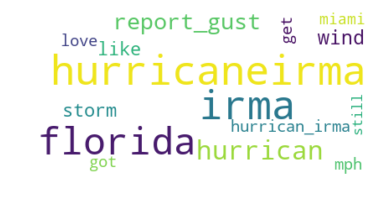

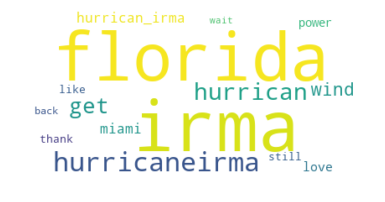

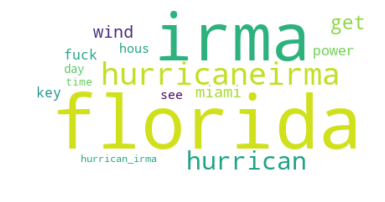

In [215]:
import wordcloud
wordcloud0 = WordCloud(background_color="white").fit_words(dict(value0_topics[:15]))
plt.figure()
plt.imshow(wordcloud0, interpolation="bilinear")
plt.axis("off")
plt.show()
wordcloud1 = WordCloud(background_color="white").fit_words(dict(value1_topics[:15]))
plt.figure()
plt.imshow(wordcloud1, interpolation="bilinear")
plt.axis("off")
plt.show()
wordcloud2 = WordCloud(background_color="white").fit_words(dict(value2_topics[:15]))
plt.figure()
plt.imshow(wordcloud2, interpolation="bilinear")
plt.axis("off")
plt.show()

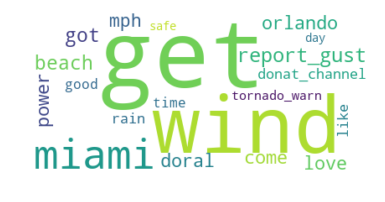

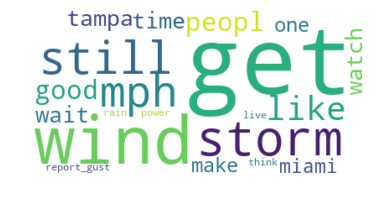

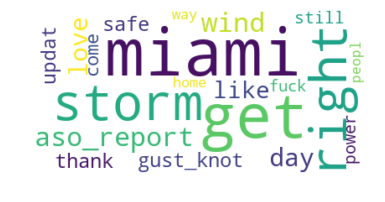

In [12]:
import itertools
import operator
from wordcloud import WordCloud

list0=[index for index, value in enumerate(values) if value == 0]
list1=[index for index, value in enumerate(values) if value == 1]
list2=[index for index, value in enumerate(values) if value == 2]

value0_topics=[]
for i in list0:
    value0_topics.extend(lda_model.show_topic(i))   
value1_topics=[]
for i in list1:
    value1_topics.extend(lda_model.show_topic(i)) 
value2_topics=[]
for i in list2:
    value2_topics.extend(lda_model.show_topic(i))

    
value2_topics=[(key,sum(i[1] for i in group)) for key, group in itertools.groupby(sorted(value2_topics, key = lambda i: i[0]), lambda i: i[0])]
value1_topics=[(key,sum(i[1] for i in group)) for key, group in itertools.groupby(sorted(value1_topics, key = lambda i: i[0]), lambda i: i[0])]
value0_topics=[(key,sum(i[1] for i in group)) for key, group in itertools.groupby(sorted(value0_topics, key = lambda i: i[0]), lambda i: i[0])]

value2_topics.sort(key = operator.itemgetter(1),reverse=True)
value1_topics.sort(key = operator.itemgetter(1),reverse=True)
value0_topics.sort(key = operator.itemgetter(1),reverse=True)

wordcloud0 = WordCloud(background_color="white").fit_words(dict(value0_topics[:20]))
plt.figure()
plt.imshow(wordcloud0, interpolation="bilinear")
plt.axis("off")
plt.show()
wordcloud1 = WordCloud(background_color="white").fit_words(dict(value1_topics[:20]))
plt.figure()
plt.imshow(wordcloud1, interpolation="bilinear")
plt.axis("off")
plt.show()
wordcloud2 = WordCloud(background_color="white").fit_words(dict(value2_topics[:20]))
plt.figure()
plt.imshow(wordcloud2, interpolation="bilinear")
plt.axis("off")
plt.show()